In [137]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [72]:
df=pd.read_csv('cardio.csv')
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [73]:
df.shape

(70000, 13)

In [74]:
#Checking missing values

df.isnull().sum()

#No missing values

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [75]:
#Checking duplicate values

df.duplicated().sum()

#No duplicate values


0

<AxesSubplot:>

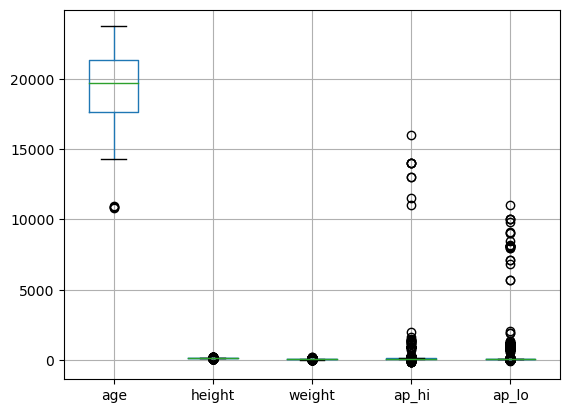

In [76]:
#Outlier detection for numerical variables
df[['age','height','weight','ap_hi','ap_lo']].boxplot()

In [77]:
#Changing the 'age' from days to years

df['age'] = (df['age']/365).astype(int)
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0


In [78]:
#Taking a column 'bmi' instead of 'height' and 'weight'

df['bmi'] = df['weight']/(df['height']/100)**2

In [79]:
#Removing 'height' and 'weight' columns

df.drop(['height','weight'], axis=1, inplace=True)

In [80]:
df.head()

,id,age,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,0,50,2,110,80,1,1,0,0,1,0,21.967120
1,1,55,1,140,90,3,1,0,0,1,1,34.927679
2,2,51,1,130,70,3,1,0,0,0,1,23.507805
3,3,48,2,150,100,1,1,0,0,1,1,28.710479
4,4,47,1,100,60,1,1,0,0,0,0,23.011177


<AxesSubplot:>

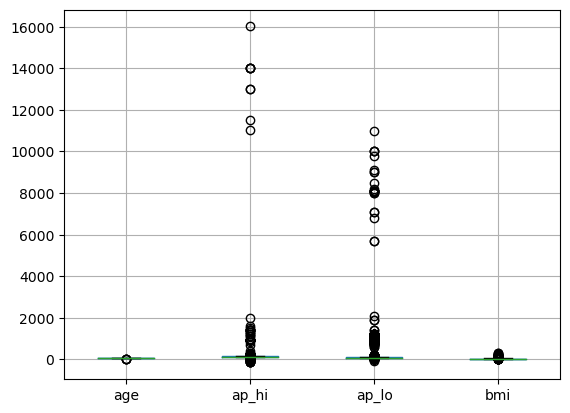

In [81]:
df[['age','ap_hi','ap_lo','bmi']].boxplot()

# Removing outliers using 1.5*IQR method

In [82]:
df_numeric=df[['age','bmi','ap_hi','ap_lo']]

Q1=df_numeric.quantile(0.25)
Q3=df_numeric.quantile(0.75)

IQR=Q3-Q1
print(IQR)

age      10.000000
bmi       6.347107
ap_hi    20.000000
ap_lo    10.000000
dtype: float64


<AxesSubplot:>

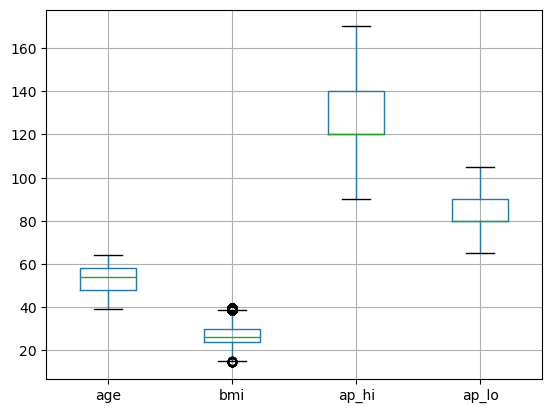

In [83]:
outlier_rows=((df_numeric<Q1-1.5*IQR)|(df_numeric>Q3+1.5*IQR)).any(axis=1)
df=df[~outlier_rows]
df[['age','bmi','ap_hi','ap_lo']].boxplot()

# Visualizing

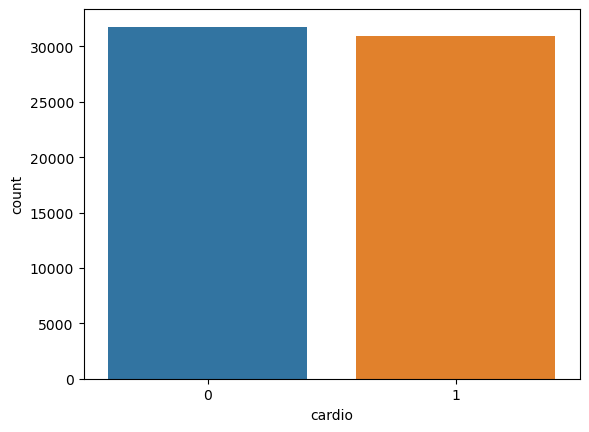

In [84]:
sns.countplot(data=df[['cardio']],x='cardio')
plt.show()

#Propotion is almost 50%

In [85]:
df['cardio'].value_counts()

0    31783
1    30962
Name: cardio, dtype: int64

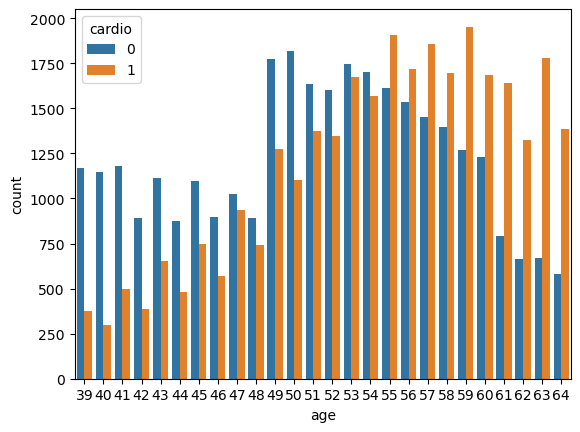

In [86]:
sns.countplot(data=df, x='age', hue='cardio')
plt.show()

#Old people tend to have cardiovascular diseases

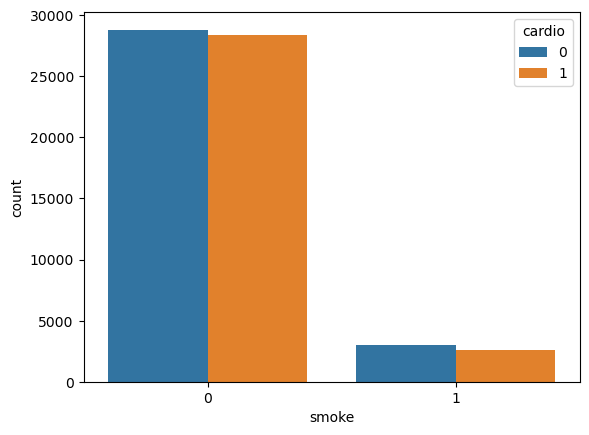

In [136]:
sns.countplot(data=df, x='smoke', hue='cardio')
plt.show()

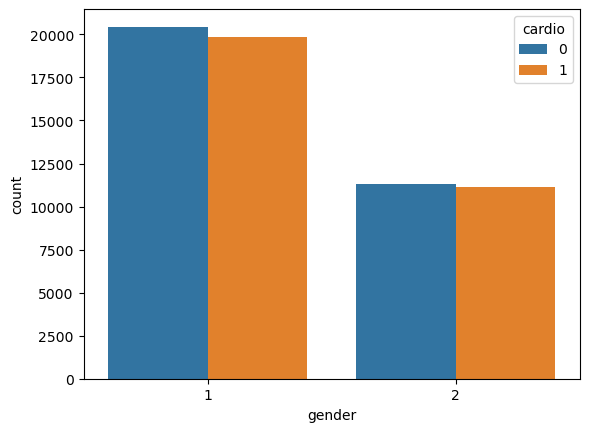

In [87]:
sns.countplot(data=df, x='gender', hue='cardio')
plt.show()

#No clear correlation between gender and cardio

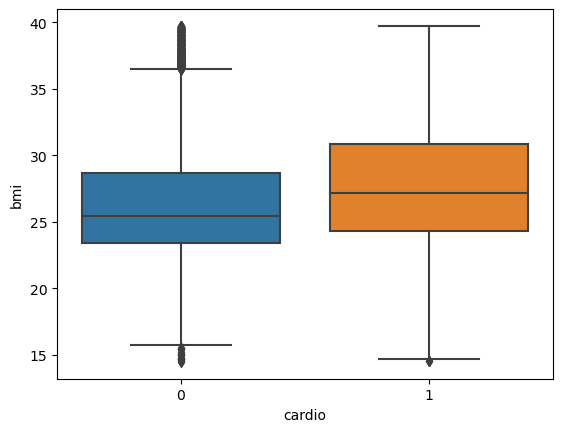

In [88]:
sns.boxplot(data=df, x='cardio', y='bmi')
plt.show()

#High bmi people have a slight tendency for cardio

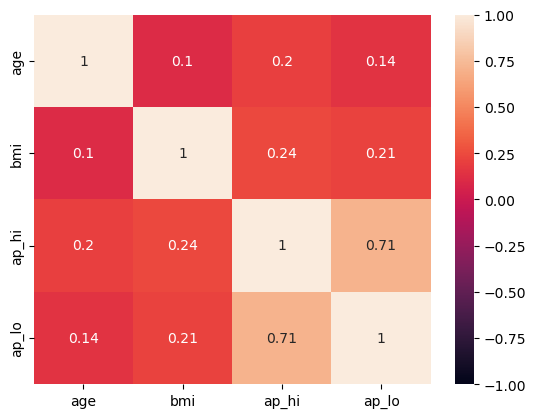

In [90]:
#heatmap of correlation

sns.heatmap(data=df[['age','bmi','ap_hi','ap_lo']].corr(), annot=True, vmin=-1, vmax=1)
plt.show()

In [91]:
data=df[['age','bmi','ap_hi','ap_lo']]
data['cardio']=['Yes' if m==1 else 'No' for m in df['cardio']]
data.head()

C:\Users\User\AppData\Local\Temp\ipykernel_12436\2794944837.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cardio']=['Yes' if m==1 else 'No' for m in df['cardio']]


,age,bmi,ap_hi,ap_lo,cardio
0,50,21.967120,110,80,No
1,55,34.927679,140,90,Yes
2,51,23.507805,130,70,Yes
3,48,28.710479,150,100,Yes
5,60,29.384676,120,80,No


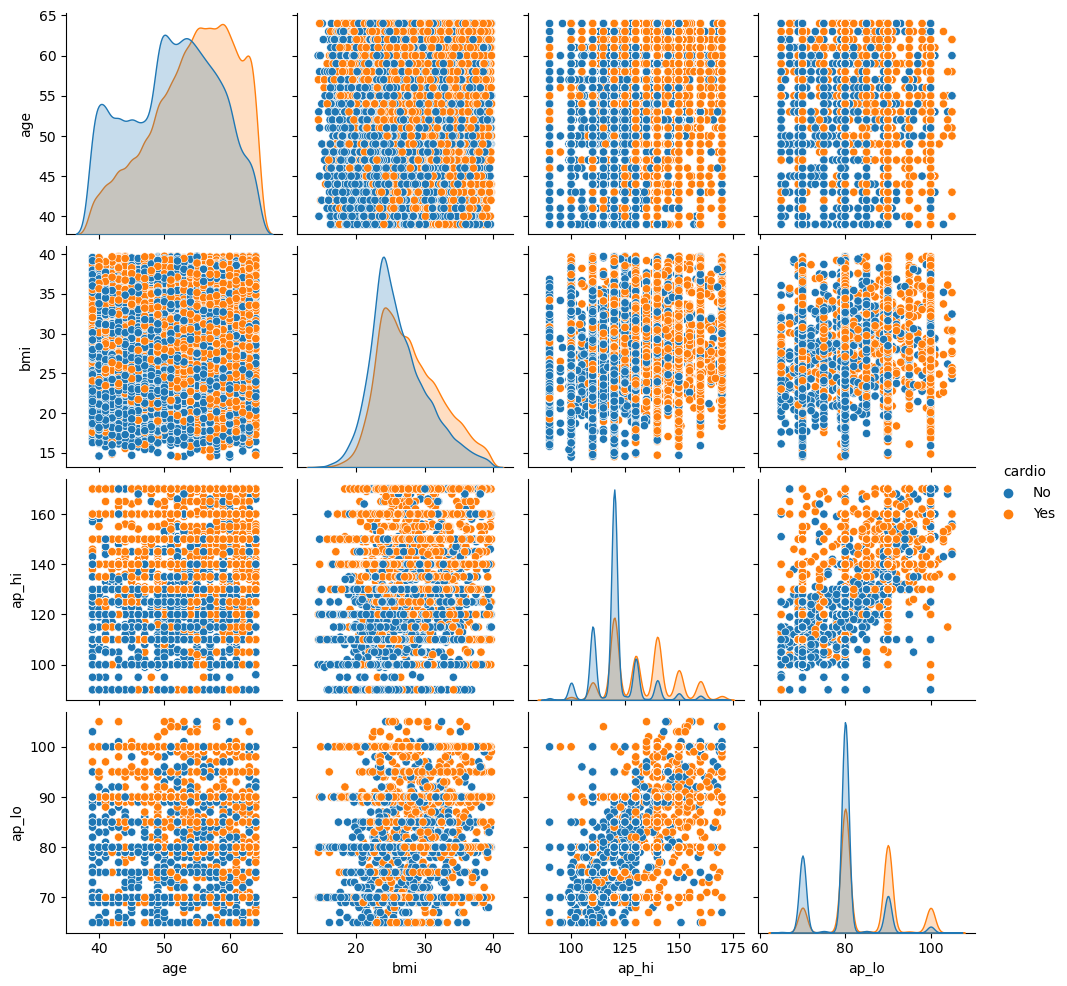

In [92]:
sns.pairplot(data, hue='cardio')
plt.show()

# Creating Models

In [93]:
df.drop('id', axis=1, inplace=True)
df=df.reindex(columns=['age','ap_hi','ap_lo','bmi','gender','cholesterol','gluc','smoke','alco','active','cardio'])
df.head()

,age,ap_hi,ap_lo,bmi,gender,cholesterol,gluc,smoke,alco,active,cardio
0,50,110,80,21.967120,2,1,1,0,0,1,0
1,55,140,90,34.927679,1,3,1,0,0,1,1
2,51,130,70,23.507805,1,3,1,0,0,0,1
3,48,150,100,28.710479,2,1,1,0,0,1,1
5,60,120,80,29.384676,1,2,2,0,0,0,0


In [94]:
#Convert 1 and 2 to 0 and 1 in 'gender' column

le=LabelEncoder()
df['gender']=le.fit_transform(df['gender'])
df.head()

,age,ap_hi,ap_lo,bmi,gender,cholesterol,gluc,smoke,alco,active,cardio
0,50,110,80,21.967120,1,1,1,0,0,1,0
1,55,140,90,34.927679,0,3,1,0,0,1,1
2,51,130,70,23.507805,0,3,1,0,0,0,1
3,48,150,100,28.710479,1,1,1,0,0,1,1
5,60,120,80,29.384676,0,2,2,0,0,0,0


In [95]:
df['gender'].value_counts()

0    40289
1    22456
Name: gender, dtype: int64

In [96]:
#Cannot use pd.get_dummies() as columns contain numerical values instead of objects
#Use one hot encoding

ohe=OneHotEncoder()
ohe_chol=ohe.fit_transform(df['cholesterol'].values.reshape(-1,1)).toarray()

#remove 1 column 

ohe_chol=ohe_chol[:,1:].astype('int')
df_chol=pd.DataFrame(ohe_chol, columns=['chol above avg','chol well above avg'])

ohe_gluc=ohe.fit_transform(df['gluc'].values.reshape(-1,1)).toarray()

#remove 1 column 

ohe_gluc=ohe_gluc[:,1:].astype('int')
df_gluc=pd.DataFrame(ohe_gluc, columns=['gluc above avg','gluc well above avg'])


In [97]:
#Reset indexing
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

In [98]:
df

,age,ap_hi,ap_lo,bmi,gender,cholesterol,gluc,smoke,alco,active,cardio
0,50,110,80,21.967120,1,1,1,0,0,1,0
1,55,140,90,34.927679,0,3,1,0,0,1,1
2,51,130,70,23.507805,0,3,1,0,0,0,1
3,48,150,100,28.710479,1,1,1,0,0,1,1
4,60,120,80,29.384676,0,2,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
62740,53,130,90,23.661439,0,1,1,0,0,1,1
62741,57,150,80,29.384757,0,1,1,0,0,1,1
62742,52,120,80,26.927438,1,1,1,1,0,1,0
62743,61,135,80,27.099251,0,1,2,0,0,0,1


In [106]:
x=pd.concat([df.iloc[:,:-1],df_chol,df_gluc], axis=1)
x.drop(['cholesterol','gluc'], axis=1, inplace=True)

In [108]:
x.head()

,age,ap_hi,ap_lo,bmi,gender,smoke,alco,active,chol above avg,chol well above avg,gluc above avg,gluc well above avg
0,50,110,80,21.967120,1,0,0,1,0,0,0,0
1,55,140,90,34.927679,0,0,0,1,0,1,0,0
2,51,130,70,23.507805,0,0,0,0,0,1,0,0
3,48,150,100,28.710479,1,0,0,1,0,0,0,0
4,60,120,80,29.384676,0,0,0,0,1,0,1,0


In [112]:
#Normalizing the first 4 variables

sc=StandardScaler()

x.iloc[:,:4]=sc.fit_transform(x.iloc[:,:4])

In [113]:
x.head()

,age,ap_hi,ap_lo,bmi,gender,smoke,alco,active,chol above avg,chol well above avg,gluc above avg,gluc well above avg
0,-0.427260,-1.147411,-0.220180,-1.150143,1,0,0,1,0,0,0,0
1,0.313890,0.950959,1.083017,1.791382,0,0,0,1,0,1,0,0
2,-0.279030,0.251502,-1.523377,-0.800469,0,0,0,0,0,1,0,0
3,-0.723719,1.650415,2.386213,0.380328,1,0,0,1,0,0,0,0
4,1.055039,-0.447954,-0.220180,0.533344,0,0,0,0,1,0,1,0


In [116]:
y=df.iloc[:,-1:]
y

,cardio
0,0
1,1
2,1
3,1
4,0
...,...
62740,1
62741,1
62742,0
62743,1


In [119]:
#train test split by 8:2

x_train,x_test,y_train,y_test=train_test_split(x.values,y.values, test_size=0.2, random_state=0)

# Hyperparameter tuning

In [ ]:
#For KNN

K=list(range(5,55,5))
err=[]
for k in K:
    modelk=KNeighborsClassifier(n_neighbors=k)
    cval=1-cross_val_score(modelk,x_train,y_train, cv=10, scoring='accuracy')
    err.append(cval.mean())

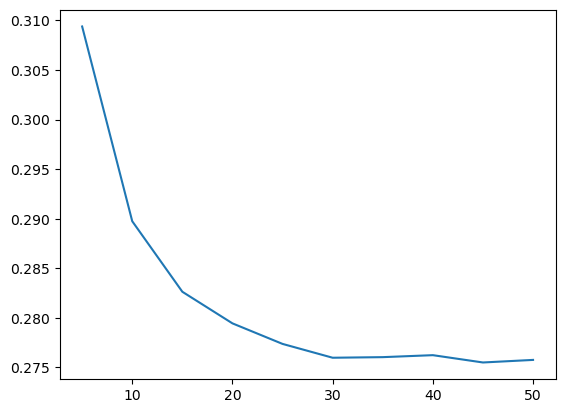

In [142]:
plt.plot(K,err)
plt.show()

In [128]:
model1=KNeighborsClassifier(n_neighbors=50)
model2=LogisticRegression()
model3=SVC(kernel='rbf',C=1)
model4=RandomForestClassifier(n_estimators=500)

T1=('knn',model1)
T2=('lgr',model2)
T3=('svc',model3)
T4=('rf',model4)

model=VotingClassifier(estimators=[T1,T2,T3,T4], voting='hard')

In [129]:
model.fit(x_train,y_train)

C:\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


VotingClassifier(estimators=[('knn', KNeighborsClassifier(n_neighbors=50)),
                             ('lgr', LogisticRegression()), ('svc', SVC(C=1)),
                             ('rf', RandomForestClassifier(n_estimators=500))])

In [130]:
y_pred=model.predict(x_test)

C:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [135]:
y_pred

array([0, 1, 0, ..., 0, 1, 0], dtype=int64)

In [131]:
confusion_matrix(y_test,y_pred)

array([[5192, 1223],
       [2228, 3906]], dtype=int64)

In [132]:
accuracy_score(y_test,y_pred)

0.7249980078093872

In [134]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.70      0.81      0.75      6415
           1       0.76      0.64      0.69      6134

    accuracy                           0.72     12549
   macro avg       0.73      0.72      0.72     12549
weighted avg       0.73      0.72      0.72     12549

